In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import heyoka as hy

from pathlib import Path

import configparser

from matplotlib import pyplot as plt

from HamiltonianSystemsTools.utils import HamiltonianSystem

from paper_utils import MapListToPixelArray, LoadPoincareMapGridDatasetInMemory, PoincareDataModule

In [7]:
cfg = "./configs/model_training/SAM_study.cfg"

In [8]:
isBool = lambda x: x.lower() == "true"
converters = {'IntList': lambda x: [int(i.strip()) for i in x.strip(" [](){}").split(',')],
    'FloatList': lambda x: [float(i.strip()) for i in x.strip(" [](){}").split(',')],
    'BoolList': lambda x: [isBool(i.strip()) for i in x.strip(" [](){}").split(',')]}
config = configparser.ConfigParser(converters=converters)
config.read(cfg)
# LOGGING params
# -------------------------------------------------------
log_dir = config.get('LOGGING', 'log_dir')
name = config.get('LOGGING', 'name')
# -------------------------------------------------------
# HARDWARE params  
# -------------------------------------------------------  
num_workers = config.getint('HARDWARE', 'num_workers')
# -------------------------------------------------------
# DATAMODULE params
# -------------------------------------------------------
randomize_flags = config.getBoolList('DATAMODULE', 'randomize')
data_dir = config.get('DATAMODULE', 'data_dir')
main_lookup_dir = config.get('DATAMODULE', 'main_lookup_dir')
local_lookup_dir = config.get('DATAMODULE', 'local_lookup_dir')
sample_fracs = config.getFloatList('DATAMODULE', 'sample_frac')
batch_size = config.getint('DATAMODULE', 'batch_size')
img_widths = config.getIntList('DATAMODULE', 'img_width')
alpha = config.getfloat('DATAMODULE', 'alpha')
min_samples = config.getint('DATAMODULE', 'min_samples', fallback=0)
max_samples = config.getint('DATAMODULE', 'max_samples', fallback=-1)
min_traj_len = config.getint('DATAMODULE', 'min_traj_len')
max_traj_len = config.getint('DATAMODULE', 'max_traj_len')
num_params = config.getint('DATAMODULE', 'num_params')
if ("param_min" in config['DATAMODULE']) or ("param_max" in config['DATAMODULE']):
    if not (("param_min" in config['DATAMODULE']) and ("param_max" in config['DATAMODULE'])):
        raise ValueError("Must specify both param_min and param_max, or neither")
    else:
        param_min = np.array(config.getFloatList('DATAMODULE', 'param_min'))
        param_max = np.array(config.getFloatList('DATAMODULE', 'param_max'))
        assert(num_params == len(param_min) == len(param_max))
else:
    param_min = None
    param_max = None

coords = config.getIntList('DATAMODULE', 'coords', fallback=[0,1])
print(f"{coords=}")
x_range = config.getFloatList('DATAMODULE', 'x_range', fallback=None)
y_range = config.getFloatList('DATAMODULE', 'y_range', fallback=None)
# -------------------------------------------------------
# TRAINER params
# -------------------------------------------------------
learning_rate = config.getfloat('TRAINER', 'learning_rate')
weight_decay = config.getfloat('TRAINER', 'weight_decay')
deterministic = config.getboolean('TRAINER', 'deterministic')
precision = config.getint('TRAINER', 'precision', fallback=16)
max_train_epochs = config.getint('TRAINER', 'max_train_epochs', fallback=-1)
max_train_steps = config.getint('TRAINER', 'max_train_steps', fallback=-1)
max_train_time = config.get('TRAINER', 'max_train_time', fallback="01:00:00:00")
print(f'{max_train_time=}, {max_train_epochs=}, {max_train_steps=}')
top_k_models =  config.getint('TRAINER', 'top_k', fallback=1)
num_runs = config.getint('TRAINER', 'num_runs', fallback=1)
# ------------------------------------------------------- 

coords=[0, 2]
max_train_time='01:00:00:00', max_train_epochs=-1, max_train_steps=25000


In [16]:
sample_frac = 0.1

assert(len(img_widths)==1)

batch_size = 4

datamodule = PoincareDataModule(
                    local_lookup_dir=local_lookup_dir,
                    data_dir=data_dir,
                    coords=coords,
                    sample_frac=sample_frac,
                    img_width=img_widths[0],
                    batch_size=batch_size, 
                    x_range=x_range,
                    y_range=y_range,
                    alpha=alpha,
                    min_samples=min_samples,
                    max_samples=max_samples,
                    min_traj_len=min_traj_len,
                    max_traj_len=max_traj_len,
                    randomize=False,
                    num_workers=num_workers,
                    verbose=True
                )

Loading dataset:
Training set...
Validation set...
Test set...
Dataset loaded.


torch.Size([4, 1, 128, 128])
tensor([[14.1641],
        [ 8.4922],
        [ 8.3984],
        [ 1.9053]], dtype=torch.float16)


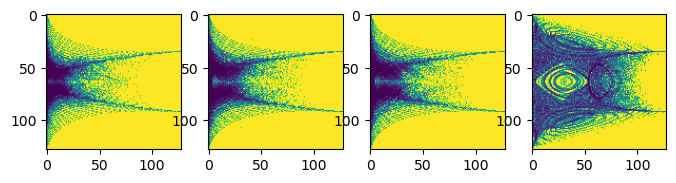

In [22]:
fig, axs = plt.subplots(1,4, figsize=(8,16))
for item in datamodule.train_dataloader():
    print(item['image'].shape)
    print(item['label'])
    for i in range(4):
        axs[i].imshow(item['image'][i,...].permute(1,2,0))
    break

plt.show()

In [25]:
def T_func(q, qd, params):
    return 1 / 2 * params[0] * (qd[0] ** 2) + 1 / 2 * (
        (qd[0] ** 2) + (q[0] ** 2) * (qd[1] ** 2)
    )  # SAM kinetic term

def U_func(q, qd, params):
    return params[0] * q[0] * params[1] - q[0] * params[1] * hy.cos(
        q[1]
    )  # SAM potential term

def L_func(q=None, qd=None, params=None):
    return T_func(q=q, qd=qd, params=params) - U_func(q=q, qd=qd, params=params)

SAM = HamiltonianSystem(num_coords=2, num_params=2, L_func=L_func)

# define Heyoka events and callbacks to record points from the Poincaré map

class ps_cb_time_stamp_cos_batch:
    def __init__(self, batch_size=4):
        self.crossing_coords = list([] for _ in range(batch_size))

    def __call__(self, ta, t, d_sgn, b_idx):
        ta.update_d_output(t)
        if np.cos(ta.d_output[1, b_idx]) > 0: # 
            self.crossing_coords[b_idx].append(
                np.array([*ta.d_output.copy()[:, b_idx], t])
            )
        return False

SAM.ps_cb_batch = ps_cb_time_stamp_cos_batch()

SAM_ps_ev_batch = hy.nt_event_batch(
    hy.sin(SAM.q[1]), direction=hy.event_direction.positive, callback=SAM.ps_cb_batch
)

In [27]:
E = 1.
mu = 3.
g = 1.0
dim_pts = 15
eps = 1e-3

t_lim = 1000.

initial_state_list = (
    [r, 0.0, p_r, None]
    for r in np.linspace(eps, E / (mu - 1.0) - eps, dim_pts)
    for p_r in np.linspace(
        -np.sqrt(2 * (mu + 1.0) * (E - (mu - 1.0) * r)) + eps,
        np.sqrt(2 * (mu + 1.0) * (E - (mu - 1.0) * r)) - eps,
        dim_pts,
    )
)

initial_state_list = SAM.fill_initial_state_list(
    initial_state_list, SAM.H, E, 3, [mu, g]
)

map_list = SAM.generate_poincare_points_ensemble_batch(
                section_event=SAM_ps_ev_batch,
                t_lim=t_lim,
                params=[mu, g],
                integral_constraint=SAM.H,
                integral_value=E,
                constrained_idx=3,
                init_state_list=initial_state_list,
                max_workers=num_workers,
                batch_size=batch_size,
            )

In [34]:
map_list

[array([[ 1.00000000e-03,  0.00000000e+00, -2.82459728e+00,
          3.75838881e-05,  0.00000000e+00],
        [ 4.99909135e-01,  6.28318531e+00,  1.17037829e-02,
          9.07051582e-03,  1.40977711e+00],
        [ 1.11431543e-03, -6.66050301e-15, -2.82446812e+00,
          3.75856067e-05,  5.65669251e+00],
        ...,
        [ 4.75047622e-01, -1.43898541e-14, -7.07351692e-04,
          1.50080009e-01,  9.94193910e+02],
        [ 6.88533654e-05,  6.28318531e+00,  2.55858669e+00,
          4.14914017e-05,  9.95607876e+02],
        [ 4.74756550e-01, -9.98422274e-16, -7.03692944e-04,
          1.50860328e-01,  9.99850763e+02]]),
 array([[ 1.00000000e-03,  0.00000000e+00, -2.42108338e+00,
          7.28415274e-04,  0.00000000e+00],
        [ 4.62436767e-01,  6.28318531e+00,  9.83920333e-03,
          1.79237491e-01,  1.41088252e+00],
        [ 1.03022672e-03,  6.43003122e-14, -2.45851625e+00,
          7.17324573e-04,  5.65682427e+00],
        ...,
        [ 1.61375609e-02, -2.1702873

In [33]:
f = MapListToPixelArray(128)
f(map_list)

TypeError: list indices must be integers or slices, not str